# Automated Browsing w/ `selenium`

This chapter provides an example of automated web browsing capabilities using the `selenium` package.

We use `selenium` when a simple HTTP request doesn't do the trick - perhaps when the pages we are trying to scrape are dynamically compiled via JavaScript (requiring a pause before all the elements are fully loaded), or when we need to perform certain interactions (like pressing buttons or typing text in input boxes). Selenium gives us the ability to programmatically interact with the websites we are browsing.






Selenium Resources:

  + <https://github.com/SeleniumHQ/selenium/tree/trunk/py>
  + <https://www.selenium.dev/selenium/docs/api/py/api.html>
  + <https://selenium-python.readthedocs.io/index.html>

:::{.callout-note}
When using `selenium` for automated web browsing locally, we can choose to browse in "headless" or "non-headless" mode. Non-headless will allow us to see the actual browser window, whereas headless mode will operate the browser without a window. When using `selenium` on a production server or in Colab, we will be operating in headless mode only.
:::

## Setup


In practice, to make `selenium` work on a local machine, we might need to also download some dependencies such as the Chromedriver and Chrome browser binary files. However in Colab, we can interface with `selenium` using [the `google-colab-selenium` package](https://pypi.org/project/google-colab-selenium/), without needing to separately install these dependencies.

Installing the `google-colab-selenium` package:

In [1]:
%%capture
!pip install -q google-colab-selenium

## Web Scraping Limitations

In this example, we will scrape a list of startup companies from the Y Combinator website:

<https://www.ycombinator.com/companies?batch=W24>



As a part of our normal web scraping process, we visit the website manually in the browser, and inspect the contents of the page to find the selectors of the elements we care about.

In this case, we see there are a number of `a` elements (i.e. hyperlinks), each with a class of `'_company_i9oky_355'`, which we can use to programmatically identify the companies. We also see that these company results are all nested inside a `div` element with a class of `"_results_i9oky_343"`.

![Inspecting the underlying contents of the page.](../../images/yc-companies-inspect.png)


:::{.callout-warning}
You'll notice some of the selectors are specific to this particular page, and may change over time. If the webmaster changes the selectors, we would have to update our solution code.
:::

Our usual next step would be to try [scraping](./html-web-scraping.qmd) the page with a normal HTTP request using the `requests` package, and then using the `BeautifulSoup` package to parse the page contents:

In [2]:
import requests

page_url = "https://www.ycombinator.com/companies?batch=W24"
response = requests.get(page_url)

In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(response.text, 'html.parser')

However after doing so, we find the requested page actually doesn't have the same content we see in the browser.


In [3]:
companies = soup.find_all('a', "_company_i9oky_355")
any(companies)

False


It looks like the page we requested programmatically has not yet been fully loaded with the page contents we care about. In practice, this may happen sometimes when certain page contents are populated dynamically (for example using an external API or data source).

To troubleshoot, to make sure we aren't getting the selectors wrong by accident, we can save the HTML contents to file, download the HTML file to our local machine, and open it in a browser to verify this page looks different / incomplete:


In [4]:
# save page source as html file to colab filesystem (for inspection):
with open("companies_page_incomplete.html", "w") as f:
    f.write(response.text)

After downloading this HTML file and opening the resulting file in our browser, we see that when the page originally loads, it doesn't have the list of companies we care about:

![Inspecting the page to see the content has not yet been loaded.](../../images/yc-startups-page-loading.png)

## Automated Browsing Solution



This motivates us to try an automated browsing solution instead, which will sometimes allow the page to fully load.

In some cases, the page might load automatically after a few seconds, while in other cases we can program in some hard-coded "sleep" time, or explicitly tell `selenium` to "wait" for certain elements to appear on the page before proceeding.

Initializing the web driver:

In [5]:
from google_colab_selenium import Chrome

driver = Chrome()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Browsing to the page:

In [6]:
page_url = "https://www.ycombinator.com/companies?batch=W24"
driver.get(page_url)
print(driver.title)

The YC Startup Directory | Y Combinator


We want to wait until the expected content has been loaded. In this case we can wait for a `<div>` element that has a class of `"_results_i9oky_343"`, which will contain  the company results we are looking for:

In [13]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

WebDriverWait(driver, 15).until(
    EC.presence_of_element_located((By.CLASS_NAME, "_results_i9oky_343"))
)

<selenium.webdriver.remote.webelement.WebElement (session="67cfbf463c3a7a7c982226f9462802a4", element="f.A0D28226BF6AE577A30B2CE75CB08686.d.EC3750904012B0862E6519250A3F1412.e.92")>

To check if the page content has been loaded, we can use the driver object's `save_screenshot` method to save an image of the page, which we can then view:

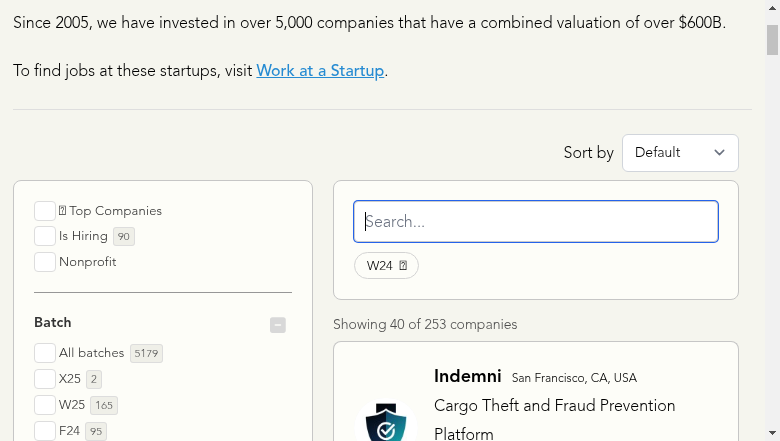

In [14]:
from IPython.display import Image, display

image_filename = "companies_page_loaded.png"
driver.save_screenshot(image_filename)
display(Image(filename=image_filename, height=300))

Alright, now it looks like the page content is fully loaded!

At this point we return to our initial attempt to use `BeautifulSoup` to parse the page, however this time we pass the driver object's `page_source` property  instead:

In [15]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(driver.page_source, 'html.parser')

In [16]:
companies = soup.find_all('a', "_company_i9oky_355")
any(companies)

True

Now we do have access to the content we care about!

In [17]:
print(len(companies))

40


We can inspect the first company to get a sense of the structure:

In [25]:
company = companies[0]
print(type(company))
print("----------")
print(company.prettify())

<class 'bs4.element.Tag'>
----------
<a class="_company_i9oky_355" href="/companies/indemni">
 <div class="relative flex w-full items-center justify-start">
  <div class="flex w-20 shrink-0 grow-0 basis-20 items-center pr-4">
   <img alt="" class="rounded-full bg-gray-100" role="presentation" src="https://bookface-images.s3.amazonaws.com/small_logos/a1ed866a0e050a4d9f6c6aeb931483100a8fcbbb.png"/>
  </div>
  <div class="flex flex-1 items-center justify-between">
   <div class="lg:max-w-[90%]">
    <div>
     <span class="_coName_i9oky_470">
      Indemni
     </span>
     <span class="_coLocation_i9oky_486">
      San Francisco, CA, USA
     </span>
    </div>
    <div>
     <span class="_coDescription_i9oky_495">
      Cargo Theft and Fraud Prevention Platform
     </span>
    </div>
    <div class="_pillWrapper_i9oky_33">
     <a class="_tagLink_i9oky_1040" href="/companies?batch=W24" target="_blank">
      <span class="pill _pill_i9oky_33">
       <svg aria-hidden="true" class="svg-i

This helps us understand the structure of each company's information on the page. In this case, we see each company has a child `<img>` element to display the company image, and various `<span>` elements for displaying the company name, description, and location:



In [26]:
img = company.find("img")
img_url = img.attrs["src"]
display(Image(url=img_url, height=100))

name = company.find("span", "_coName_i9oky_470")
print(name.text)

loc = company.find("span", "_coLocation_i9oky_486")
print(loc.text)

desc = company.find("span", "_coDescription_i9oky_495")
print(desc.text)

href = company.attrs["href"]
print(f"https://www.ycombinator.com{href}")

Indemni
San Francisco, CA, USA
Cargo Theft and Fraud Prevention Platform
https://www.ycombinator.com/companies/indemni


We can now loop through all the companies (or for demonstration purposes, just the first five) to automate the process of gathering and/or displaying this data:

In [30]:
for company in companies[0:5]:
    print("----------------")

    name = company.find("span", "_coName_i9oky_470")
    print(name.text)

    loc = company.find("span", "_coLocation_i9oky_486")
    print(loc.text)

    desc = company.find("span", "_coDescription_i9oky_495")
    print(desc.text)


----------------
Indemni
San Francisco, CA, USA
Cargo Theft and Fraud Prevention Platform
----------------
ParcelBio
San Francisco, CA, USA
Next-generation mRNA medicines
----------------
K-Scale Labs
Palo Alto, CA, USA
Open-source humanoid robots
----------------
Marr Labs
San Francisco, CA, USA
AI-voice agents that are indistinguishable from humans.
----------------
Forge Rewards
San Francisco, CA, USA
Starbucks app for restaurants


Finally, as a best practice, once we are done, we shut down the web driver, to save memory:

In [23]:
driver.quit()

That's it, you are automated browsing like a pro!